# Easy Parallelization with GillesPy2
***
## Setup the Environment
***

In [1]:
import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), '../..')))

In [2]:
from dask.distributed import Client
from dask import delayed, compute

In [3]:
import gillespy2

***
## Build the Example Model
***

In [4]:
def build_michaelis_menten(parameter_values=None):
    # Initialize Model
    model = gillespy2.Model(name="Michaelis_Menten")

    # Define Variables (GillesPy2.Species)
    A = gillespy2.Species(name='A', initial_value=301)
    B = gillespy2.Species(name='B', initial_value=120)
    C = gillespy2.Species(name='C', initial_value=0)
    D = gillespy2.Species(name='D', initial_value=0)
    
    # Add Variables to Model
    model.add_species([A, B, C, D])

    # Define Parameters
    rate1 = gillespy2.Parameter(name='rate1', expression= 0.0017)
    rate2 = gillespy2.Parameter(name='rate2', expression= 0.5)
    rate3 = gillespy2.Parameter(name='rate3', expression = 0.1)
    
    # Add Parameters to Model
    model.add_parameter([rate1, rate2, rate3])

    # Define Reactions
    r1 = gillespy2.Reaction(name="r1", reactants={'A': 1, 'B': 1}, products={'C': 1}, rate='rate1')
    r2 = gillespy2.Reaction(name="r2", reactants={'C': 1}, products={'A': 1, 'B': 1}, rate='rate2')
    r3 = gillespy2.Reaction(name="r3", reactants={'C': 1}, products={'B': 1, 'D': 1}, rate='rate3')
    
    # Add Reactions to Model
    model.add_reaction([r1, r2, r3])
    
    # Define Timespan
    tspan = gillespy2.TimeSpan.linspace(t=100, num_points=101)
    
    # Set Model Timespan
    model.timespan(tspan)
    return model

### Instantiate the Model

In [5]:
model = build_michaelis_menten()

### Instantiate the Solver
For best performance, use the C solver and pre-compile by instantiating the solver with the model as the argument, and assigning it to a variable

In [6]:
solver = gillespy2.SSACSolver(model)

***
## Run the Simulations
***
### Benchmark: Serial

In [7]:
%time serial_results = model.run(solver=solver, number_of_trajectories=1000)

CPU times: user 184 ms, sys: 8.28 ms, total: 193 ms
Wall time: 408 ms


### Using Dask
#### Create Dask client and set n_workers/threads

In [8]:
c = Client(n_workers=2, threads_per_worker=4)
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52192,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:52200,Total threads: 4
Dashboard: http://127.0.0.1:52201/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:52196,


#### Create a list of delayed simulations

In [9]:
num_trajectories = 100
simulations = []
for i in range(num_trajectories):
    sim_thread = delayed(model.run)(solver=solver, seed=i+1, number_of_trajectories=1)
    simulations.append(sim_thread)

#### Execute all simulations.
Results are returned as a list of individual simulations

In [10]:
%time dask_results = compute(*simulations, scheduler='threads')

CPU times: user 52.3 ms, sys: 198 ms, total: 250 ms
Wall time: 241 ms


#### Create a single ensemble Results object from all results

In [11]:
ensemble = sum(dask_results)

#### Shutdown Dask Client

In [12]:
c.close()

***
## Visualizations
***

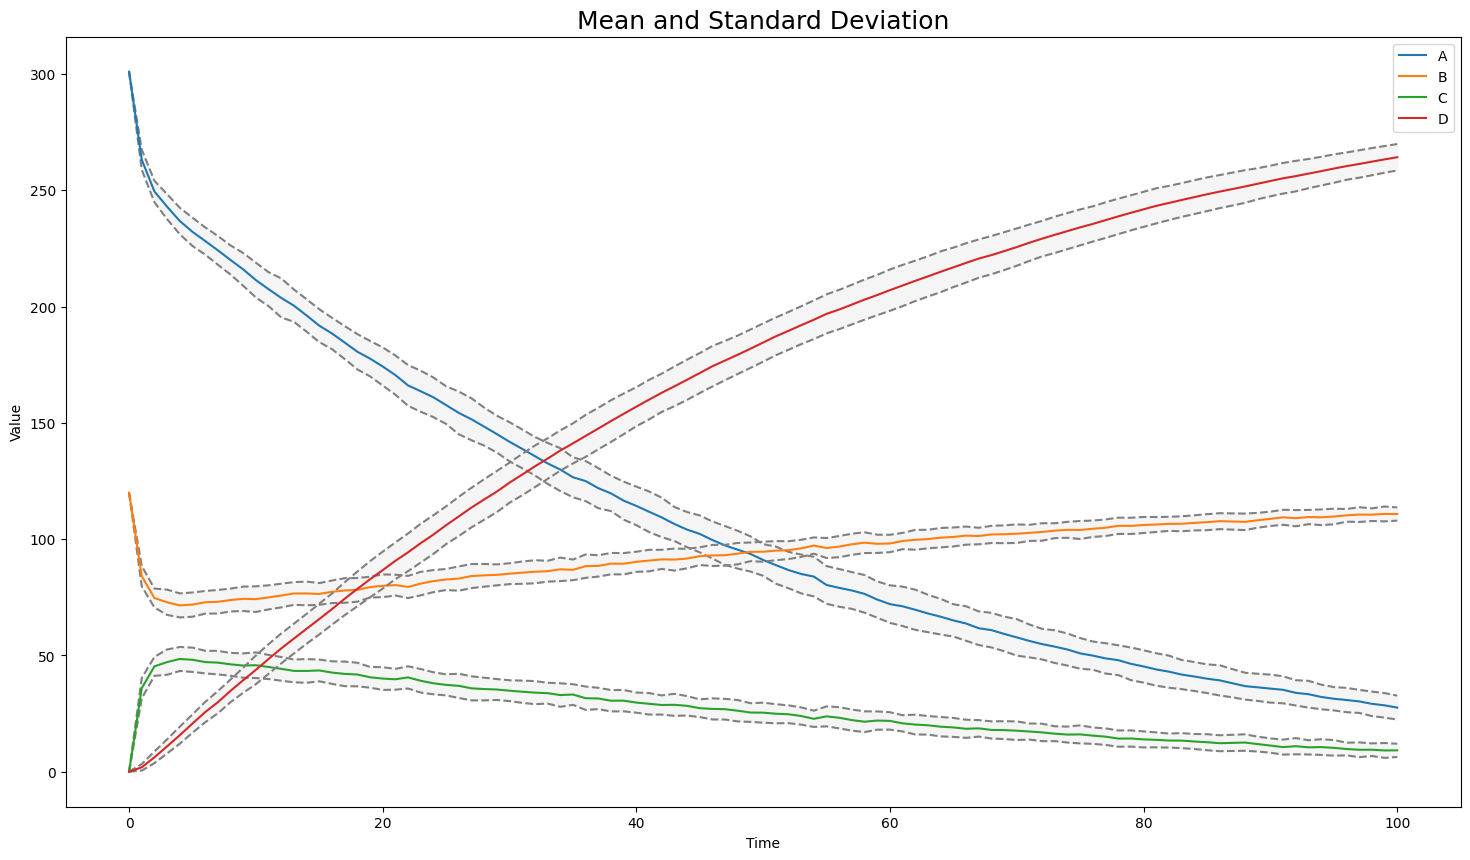

In [13]:
ensemble.plot_mean_stdev()